# Projet de télédétection avancé 
## Par Gabriel Rigal 
### Pour Monsieur Marc Lang et Madame Yousra Hamrouni


#### Chemin des fichiers d'entrée

In [35]:
#4.2.1 Nombre d’échantillons
echantillon_filepath = '/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp'
img_filepath = '/home/onyxia/work/data/projet_eval/pyrenees_23-24_B02.tif' #image de référence 

# 4.2.2 Phénologie des strates, mise en évidence des landes
B2 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B02.tif"
B3 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B03.tif"
B4 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B04.tif"
B5 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B05.tif"
B6 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B06.tif"
B7 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B07.tif"
B8 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B08.tif"
B8A = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B8A.tif"
B11 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B11.tif"
B12 = "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B12.tif"


# 4.3 
raster_features_path = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/ARI_serie_temp.tif"


#### Chemin des fichiers de sortie

In [36]:
#4.2.1 Nombre d’échantillons
echantillon_rasterize = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/echantillon_rasterize.tif"
diagram_poly_filepath = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/figure/diag_baton_nb_poly_by_class.png"
diagram_pixel_filepath = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/figure/diag_baton_nb_pix_by_class.png"

# 4.2.2 Phénologie des strates, mise en évidence des landes
B5_10m = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/B5_10m.tif"
Ari = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/ARI_serie_temp.tif"
graph_ari = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/figure/ARI_series.png"

# 4.3 
echantillon_rasterize_id = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/echantillon_rasterize_ID.tif"
output_carte_final = "/home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/carte_strates.tif"



#### Bibliothèques et fonctions utilisées

In [37]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import geopandas as gpd
from osgeo import gdal, ogr

from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedGroupKFold,
    GridSearchCV,
    train_test_split,
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF

sys.path.append('/home/onyxia/work/libsigma')

from plots import plot_class_quality
from classification import rasterization
from read_and_write import (
    get_origin_coordinates,
    get_pixel_size,
    get_image_dimension,
    load_img_as_array,
    write_image,
)


# Description de la méthode :
La démarche devra être décrite de telle sorte qu’elle puisse être reproduite. Elle sera accompagnée d’un diagramme de flux détaillant tous les traitements réalisés, les couches en entrée utilisées et les paramètres principaux.

Le présent rapport fait état d'une méthode de classification de landes à partir de la bibliothèque scikit-learn. Le diagramme de flux suivant ce paragraphe de texte permet de le résumer. 

![Un diagramme de flux devrait s'afficher, merci de vérifier le chemin de vos données](/home/onyxia/work/data/Diag2.drawio.png "Diagramme de flux")


Ce rapport se divise en plusieurs parties, la première étant l'analyse des échantillons. Indispensable au bon choix de notre classifieur, elle permettra également de produire une analyse plus poussée de nos données. 
Pour se faire, une analyse du nombre d'échantillons par pixels et par polygones à partir de notre fichier d'échantillon sera entrepris. Puisqu'il s'agit d'un fichier shape de polygones, il ne sera pas complexe de réaliser l'analyse par polygones. En effet, il suffira de compter le nombre de polygones contenant la valeur 1,2,3 ou 4 dans le champ "strates" puis de les stocker dans un dictionnaire. Il en sera de même pour compter les pixels, à la différence que l'échantillon devra être rasterisée en amont à la taille d'une de nos images d'étude et la valeur des pixels doit être décidée par leur valeur au sein du champ "strates". Une fois cela fait, on peut désormais créé un dictionnaire contenant le nombre de pixel aux valeurs 1,2,3 et 4.

Une fois cela fait, un graphique peut être créé à partir de chacun des dictionnaires créés.

La deuxième partie de ce rapport est la mise en évidence des landes par le calcul de l'indice d'ARI (ou NARI pour Normalized Anthocyanin Reflectance Index). Pour se faire, il faut réaliser ce calcul : (1/B3 - 1/B5) / (1/B3 + 1/B5). Nos séries temporelles étant triées dans le même ordre, il nous suffit de réaliser ce calcul dans une boucle où la bande B1 est calculée par le calcul d'Ari issu des bandes 1 de nos séries temporelles puis la bande B2 est calculée par les bandes B2 de nos séries temporelles et ainsi de suite. 
Pour réaliser ce calcul, nos séries temporelles B3 et B5 ont été transformées en tableau numpy. La boucle à ensuite été réalisée avant de stocker le résultat de la boucle (lui-même étant un tableau) au sein d'une image. Enfin, les valeurs moyennes de l'écart type de chacune des bandes sont calculées, nous permettant de créer un graphique des valeurs d'ARI par dates et selon les strates. 

Il est important de noter que dans notre cas, les données ont été préparées de sortie que la bande B5, ayant normalement une résolution de 20m par 20m ont été ré-échantillonnée à une résolution de 10m par 10m. Le rapport prend en compte le fait que ce n'est généralement pas le cas et propose une méthode où la série temporelle est ré-échantillonée, bien que ce ne soit pas nécessaire avec les données qui nous sont fournies. 

Enfin, la dernière partie de ce rapport présente la réalisation d'une classification à partir de nos données. Justement, les données en entrée sont le fichier d'échantillons rasterisés pour les pixels d'entraînements et de tests (Y) et l'ensemble des bandes qui nous ont été fournies (B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12) accompagné de l'indice spectral calculé et ce, sur l'ensemble de nos 15 dates s'étalant du 25 septembre 2023 au 22 août 2024. Cela donne donc un total de 150 bandes. Egalement, il sera démontré au sein de ce rapport que la stratégie de cross validation de la classification "StratifiedGroupkfold" sera préféré à la stratégie "StratifiedKfold" malgré des résultats à priori meilleurs (cf partie 4.3.1 - Définition de la stratégie de cross validation). Ainsi, des paramètres Group_train et Group_test seront également créés à partir des échantillons rasterisés. Ils permettront au classifieur de ne pas entraîner et tester des pixels issus d'un même polygone d'entraînement. 

Suite à cela, la valeur de K sera définie sur 5 grâce à une méthode d'essai tests en se fiant principalement au F1-score en sortie. Une explication plus détaillée est retrouvable dans la partie 4.3.1 - Définition de la stratégie de cross validation. Une fois que ces paramètres sont décidés, l'algorithme GridSearchCV de scikit-learn permet de définir les meilleurs paramètres selon ceux que nous avons pré-sélectionnés. Dans notre cas, les réglages proposés sont les suivants : n_estimators	: 50, 100, 150, 200, 300 ; max_depth : None, 10, 15, 20 max_features : None, sqrt, log2 min_samples_leaf : 1, 5. 
En sortie, le résultat de GridSearchCV nous permet de réaliser notre classification, d'abord au format d'un tableau, puis nous l'enregistrons en tant qu'image en .tiff. Dans le même temps, nous pouvons réaliser l'analyse de l'importance des variables et la matrice de confusion. Au vue du nombre de variable, un tableau sera préféré, afin de représenter facilement l'ensemble de nos variables utilisées par le modèle. 

Nous y reviendrons lors de l'analyse de nos résultats, mais nous garderons en tête l'idée selon laquelle la matrice de confusion n'est qu'un indicateur calculé à partir de nos pixels tests, et c'est en ce sens qu'une analyse de la classification sera également réalisée via photo-interprétation. 

C'est en ce sens qu'une analyse de la carte sera réalisée par photo-interprétation. 
Ainsi, la classification sera comparée à ce que l'on peut constater via la photo interprétation de l'image Ortho IRC et vraies couleurs de l'IGN (Institut Géographique National) de 2024. La première idée fut d'étudier la composition colorée vraie couleur de l'image la plus importante pour notre modèle, c'est-à-dire celle du 13 mars 2024. L'intérêt aurait été de simplement de comparer les grands éléments de notre classification, sans pour autant mettre de côté le fait que l'image de comparaison ne caractérise que 19 % des dates servant au modèle. Pour autant, il a finalement été décidé d'utiliser cette méthode car elle permet une résolution à 10m et permet d'être mis en place rapidement. Une limite de cette méthode est relative à notre terrain d'étude. En effet, notre classification est réalisée à cheval entre le département des Pyrénées Atlantiques et la frontière espagnole. Ainsi, puisqu'une part sud-ouest de notre image est située en Espagne, et que l'IGN, institut d'état français, ne cartographie que la France, nous ne pourrons pas étudier cette zone au regard de l'Ortho IRC de l'IGN. Pour autant, nous considérerons que cette dernière est dispensable à l'étude globale de la classification.

De plus, puisque notre image de comparaison ne couvre que la période de 2024 et que notre classification s'applique à des images de 2023 et 2024, il faudra également prendre en compte cette particularité lors de l'analyse. Concrètement, cela signifie qu'il est possible que certaines landes visibles sur l'ortho IRC ne soient pas visibles sur toutes les images dont la classification est issue. Pour autant, il apparaît peu probable que sur cette période, les forêts et les routes, constituant les classes d'arbre et de sol nu, se soient déplacés. 


## 4.2. Analyse des échantillons

### 4.2.1. Nombre d'échantillons

#### Création des diagramme en bâton : 

##### Création du dictionnaire qui compte le nombre de polygone par classes

In [38]:
# Nom du champ contenant la classe
class_field = "strate"

gdf = gpd.read_file(echantillon_filepath)

# Dictionnaire : nombre de polygones par classe
poly_count_per_class = gdf[class_field].value_counts().to_dict()

poly_count_per_class


{3: 78, 2: 69, 4: 31, 1: 28}

##### Création du dictionnaire qui compte le nombre de pixels par classes
Il faut d'abord rasteriser le fichier d'échantillon pour ensuite compter les pixels que contiennent les polygones dont la valeur est égale à la classe à laquelle ils correspondent.  
Pour cela, on récupère les informations d'une de nos images afin que le raster des échantillon corresponde aux rasters qui seront classifiés (taille et résolution).

In [39]:
data_set = gdal.Open(img_filepath)

get_origin_coordinates(data_set, verbose=True)
get_pixel_size(data_set, verbose=True)
get_image_dimension(data_set, verbose=True)


Origin = (684590.0, 4761380.0)
Pixel Size = (10.0, -10.0)
Number of columns : 2103
Number of lines : 1655
Number of bands : 15


(1655, 2103, 15)

In [40]:
# Récupération des paramètres de nos images 
sptial_resolution = 10
xmin = 684590.0
ymax = 4761380.0
pixel_width = 10
pixel_height = -10
cols = 2103
rows = 1655

# Calcul des paramètres supplémentaires de nos images 
xmax = xmin + cols * pixel_width
ymin = ymax + rows * pixel_height

# Définition des commandes à entrer en paramètres
cmd_pattern = (
    "gdal_rasterize -a {field_name} "
    "-tr {sptial_resolution} {sptial_resolution} "
    "-te {xmin} {ymin} {xmax} {ymax} -at -ot Byte -of GTiff "
    "{in_vector} {out_image}"
)

# On complète les paramètres au format fonction
cmd = cmd_pattern.format(
    in_vector=echantillon_filepath,
    xmin=xmin,
    ymin=ymin,
    xmax=xmax,
    ymax=ymax,
    out_image=echantillon_rasterize,
    field_name=class_field,
    sptial_resolution=sptial_resolution
)

os.system(cmd)


0...10...20...30...40...50...60...70...80...90...100 - done.


0

Maintenant que notre fichier shape est rasterisé on peut compter les pixels de chaque classes et le mettre dans un dictionnaire.

In [41]:
# Ouvrir le raster
data_set_pixel_count = gdal.Open(echantillon_rasterize)
band_rasterize = data_set_pixel_count.GetRasterBand(1)

# Lire les pixels
arr = band_rasterize.ReadAsArray()

# Valeurs uniques et leurs comptes
values, counts = np.unique(arr, return_counts=True)

pixel_count_per_class = {}

for v, c in zip(values, counts):
    if v != 0:
        pixel_count_per_class[int(v)] = int(c)

pixel_count_per_class


{1: 132, 2: 313, 3: 364, 4: 141}

Maintenant que les deux dictionnaires ont été créés nous pouvons les mettre en forme de diagramme en bâton et les stocker dans un dossier results/figures

 On créé le diagramme baton des polygones par classes

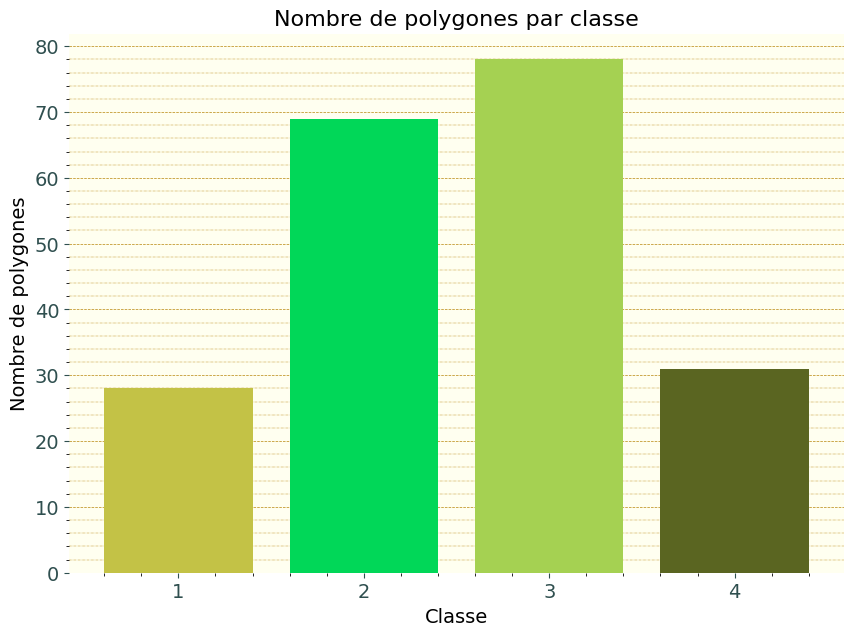

In [42]:
# Données
classes = list(poly_count_per_class.keys())
pixel_counts = list(poly_count_per_class.values())

# Couleurs par classe
class_colors = {
    1: "#c3c246",  # jaune orangé pour le sol nu
    2: "#01d758",  # vert clair pour l'herbe 
    3: "#a5d152",  # vert buisson pour les landes
    4: "#5a6521"   # vert foncé pour les forêts 
}
colors = [class_colors[c] for c in classes]

# Figure
fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(classes, pixel_counts, color=colors, zorder=2)

# Titre
ax.set_title("Nombre de polygones par classe", fontsize=16)

# Fond
ax.set_facecolor('ivory')

# Labels
ax.set_xlabel("Classe", fontsize=14)
ax.set_ylabel("Nombre de polygones", fontsize=14)

# Forcer les ticks X
ax.set_xticks(classes)
ax.set_xticklabels(classes)

# Bordures
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Ticks
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)

# Grille
ax.minorticks_on()
ax.yaxis.grid(
    which='major',
    color='darkgoldenrod',
    linestyle='--',
    linewidth=0.5,
    zorder=1
)
ax.yaxis.grid(
    which='minor',
    color='darkgoldenrod',
    linestyle='-.',
    linewidth=0.3,
    zorder=1
)

# Sauvegarde dans le fichier results/figure
plt.savefig(diagram_poly_filepath, dpi=300, bbox_inches="tight")


#### Commentaires : 

On constate assez facilement que les deux polygones les plus représentés sont ceux des classes 2 et 3 (herbes et landes). Cela peut sembler logique puisque ces deux classes ont des signatures spectrales relativement proches. Ainsi, il faut leur apporter une attention particulière.  

Par opposition, la classe 1 (sol nu) possède des valeurs de réflectances éloignées des trois autres classes, ainsi, le fait qu'elle soit la classe la moins représentée ne devrait pas poser beaucoup de problèmes pour la classification. Enfin, la classe 4 (arbre) est la deuxième classe la moins représentée et l'est beaucoup moins que les classes 2 et 3. Or dans la mesure où  celle-ci renvoie également à de la végétation, il existe un risque qu'on confonde la classe 4 avec les classes 2 et 3.  

Néanmoins, ces idées ne sont qu'un commentaire et savoir ou non s'il existe un risque de sous-entraînement demande une analyse plus poussée. De même, le nombre de polygones ne renvoie pas totalement à l'importance de ces derniers pour entraîner un modèle. Leur taille en revanche peut être un indicateur pertinent. 

 On reprend la même chose pour le diagramme baton des pixels par classes :


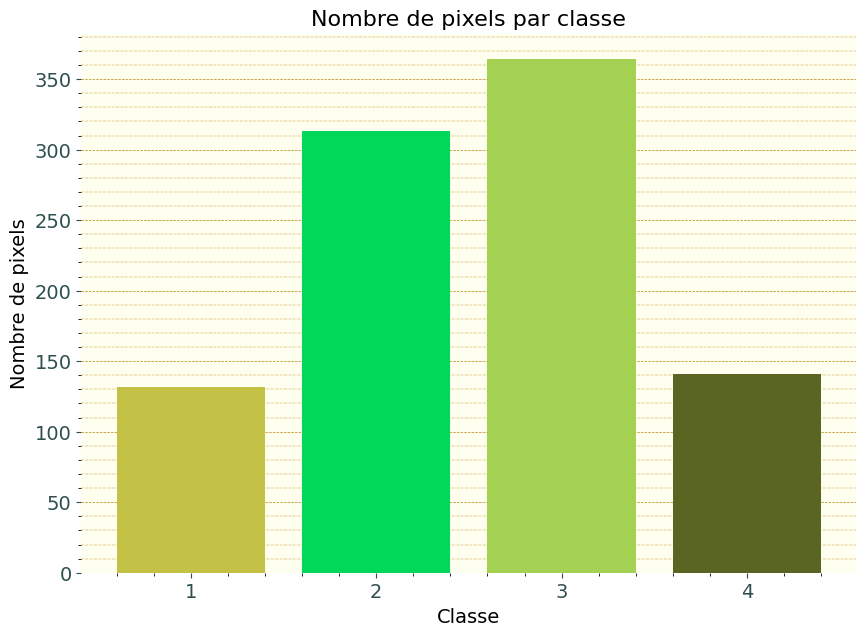

In [43]:
# Données
classes = list(pixel_count_per_class.keys())
pixel_counts = list(pixel_count_per_class.values())

# Couleurs par classe
class_colors = {
    1: "#c3c246",  # jaune orangé pour le sol nu
    2: "#01d758",  # vert clair pour l'herbe 
    3: "#a5d152",  # vert buisson pour les landes
    4: "#5a6521"   # vert foncé pour les forêts  
}
colors = [class_colors[c] for c in classes]

# Figure
fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(classes, pixel_counts, color=colors, zorder=2)

# Titre
ax.set_title("Nombre de pixels par classe", fontsize=16)

# Fond
ax.set_facecolor('ivory')

# Labels
ax.set_xlabel("Classe", fontsize=14)
ax.set_ylabel("Nombre de pixels", fontsize=14)

# Forcer les ticks X
ax.set_xticks(classes)
ax.set_xticklabels(classes)

# Bordures
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Ticks
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)

# Grille
ax.minorticks_on()
ax.yaxis.grid(
    which='major',
    color='darkgoldenrod',
    linestyle='--',
    linewidth=0.5,
    zorder=1
)
ax.yaxis.grid(
    which='minor',
    color='darkgoldenrod',
    linestyle='-.',
    linewidth=0.3,
    zorder=1
)

# Sauvegarde dans le fichier results/figure
plt.savefig(diagram_pixel_filepath, dpi=300, bbox_inches="tight")


#### Commentaires : 

On constate assez simplement que les classes les plus représentées sont les mêmes que sur le diagramme par polygone (classes 2 et 3). 
  
Par ailleurs, bien que l'écart entre ces classes (les classes 1 et 4 sont plus de deux fois moins représentées que les classes 2 et 3) soit équivalent, on constate que le nombre de pixels définis par les classes 1 et 4 sont proches.   
De même, c'est la classe trois qui est la plus représentée, ce qui n'est pas choquant lorsque nous prenons en compte le fait que ce sont les landes qui sont le plus dur à différencier des autres classes.   
De l'autre côté, la classe 1 ne devrait pas avoir de mal à être classée malgré sa faible représentation dans l'échantillon puisque cette classe ne renvoie pas à de la végétation. 

### 4.2.2. Phénologie des strates, mise en évidence des landes

#### Calcul du Ari pour l'entièreté de la série temporelle :



Dans notre cas, la bande B5 est déjà ré-échantillonnée, mais elle est à l'origine fournie à une résolution de 20m par 20m, cela a été pris en compte.

In [44]:
# Avant de commencer, il faut passer la résolution de B5 de 20 à 10m
B5_gdal = gdal.Open(B5)

new_res = 10 

# Rééchantillonnage avec gdal.Warp
gdal.Warp(
    B5_10m,
    B5_gdal,
    xRes=new_res,
    yRes=new_res,
    resampleAlg=gdal.GRA_Bilinear,
    multithread=True
)

# On charge ensuite nos images à la même résolution en tableau numpy 
tableau_b3 = load_img_as_array(B3).astype(np.float32)
tableau_b5 = load_img_as_array(B5_10m).astype(np.float32)

# Boucle pour calculer l'ARI à l'échelle de la série temporelle via tableau numpy
result = np.zeros_like(tableau_b3)
for i in range(tableau_b3.shape[2]):
    result[:, :, i] = (
        (1 / tableau_b3[:, :, i] - 1 / tableau_b5[:, :, i]) /
        (1 / tableau_b3[:, :, i] + 1 / tableau_b5[:, :, i])
    )

# On passe le nodata en -9999
result = np.nan_to_num(result, nan=-9999)

# On écrit le tableau dans une image.tiff
write_image(Ari, result, data_set=B5_gdal, gdal_dtype=gdal.GDT_Float32)


#### Création du graphique Ari_series.png :

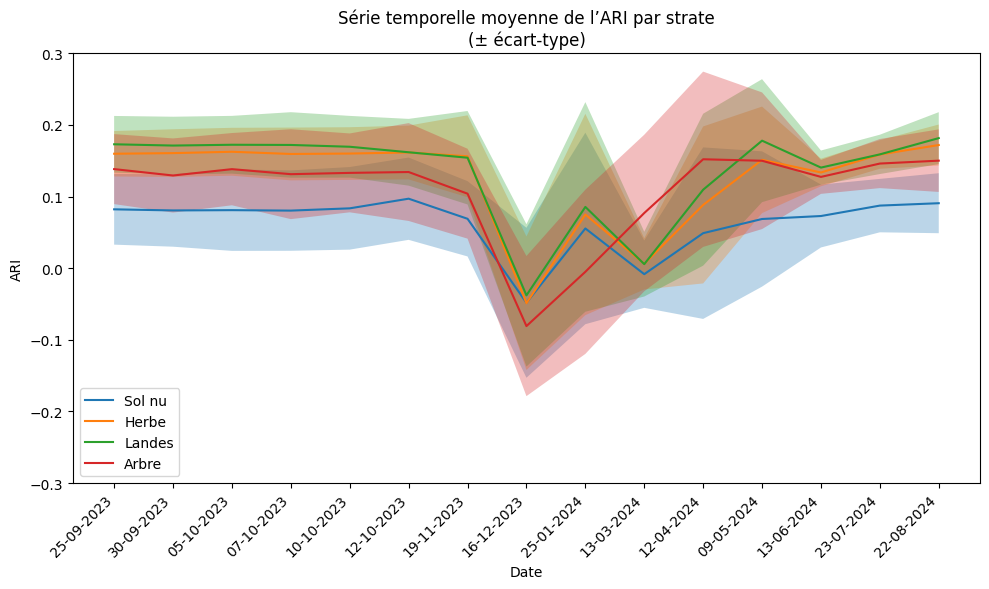

In [45]:
# Chargement des données en tableau numpy 
classes_np = load_img_as_array(echantillon_rasterize)
ARI = load_img_as_array(Ari).astype(np.float32)

classes_sq = np.squeeze(classes_np)

# Nomme les variables proprement
class_names = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

dates = [
    "25-09-2023", "30-09-2023", "05-10-2023", "07-10-2023",
    "10-10-2023", "12-10-2023", "19-11-2023", "16-12-2023",
    "25-01-2024", "13-03-2024", "12-04-2024", "09-05-2024",
    "13-06-2024", "23-07-2024", "22-08-2024"
]

n_time = ARI.shape[2]

fig, ax = plt.subplots(figsize=(10, 6))

# Calcul des moyennes et écarts types
for c, label in class_names.items():
    mask = (classes_sq == c)

    X = ARI[mask]
    X = X[~np.any(X == -9999, axis=1)]

    mean_ari = X.mean(axis=0)
    std_ari = X.std(axis=0)

    ax.plot(mean_ari, label=label)
    ax.fill_between(
        range(n_time),
        mean_ari - std_ari,
        mean_ari + std_ari,
        alpha=0.3
    )

# Décoration pour rendre le graphique compréhensible
ax.set_xticks(range(n_time))
ax.set_xticklabels(dates, rotation=45, ha="right")

ax.set_xlabel("Date")
ax.set_ylabel("ARI")
ax.set_ylim(-0.3, 0.3)
ax.set_title("Série temporelle moyenne de l’ARI par strate\n(± écart-type)")
ax.legend()

plt.tight_layout()

# Sauvegarde du graphique
plt.savefig(graph_ari, dpi=300, bbox_inches="tight")


#### Commentaires : 

L'analyse de ce graphique permet de mieux comprendre nos données. En effet, les valeurs d'ARI de nos strates varient au cours du temps. On constate ainsi que la phénologie des plantes a un impact direct sur nos résultats. Par exemple, on peut voir que les 4 classes sont en moyenne bien différenciées entre les mois d'août et d'octobre, tandis qu'elles ont tendance à se chevaucher entre décembre et juin.  
On remarque d’ailleurs un décrochage brutal à la mi-décembre, où l’ensemble des indices chute vers des valeurs négatives, rendant toute distinction temporairement impossible. 
   
 Autrement dit, la fin de l'été et le début de l'automne sont la période optimale pour détecter nos strates avec l'indice ARI. Au contraire, les chevauchements en dehors de cette période sont courants. C'est notamment le cas au printemps (avril-mai) : on observe une remontée rapide de la courbe des arbres qui finit par dépasser les autres strates, bien que cela s'accompagne d'une forte augmentation de leur écart-type. D'une manière générale, l'écart-type est tel que l'on a du mal à distinguer les différentes classes auxquelles il renvoie.
  
Ainsi, on peut en déduire que les classes auront du mal à être différenciées entre elles. Assez peu étonnamment, les deux classes dont les valeurs sont les plus proches sont l'herbe et les landes. Enfin, malgré quelques chevauchements et un écart-type qui se mélange aux autres classes, les sols nus restent les plus différenciés par rapport aux autres strates sur l'ensemble de l'année.

## 4.3. Production d’une carte de strates à l’échelle du pixel

### 4.3.1. Choix du classifieur et sa paramètrisation et 4.3.2.

Les X sont donc notre série temporelle d'ARI tandis que les Y sont issus de notre couche d'échantillons rasterisés. A partir de ces deux couches, nous pouvons créer notre jeu d'X et d'Y d'entraînement et de test.

In [46]:
# Permet la classification en GROUP de StratifiedGroupK-fold

id = 'id'

# Récupération des paramètres de nos images 
sptial_resolution = 10
xmin = 684590.0
ymax = 4761380.0
pixel_width = 10
pixel_height = -10
cols = 2103
rows = 1655

# Calcul des paramètres supplémentaires de nos images 
xmax = xmin + cols * pixel_width
ymin = ymax + rows * pixel_height

# Définition des commandes à entrer en paramètres
cmd_pattern = (
    "gdal_rasterize -a {field_name} "
    "-tr {sptial_resolution} {sptial_resolution} "
    "-te {xmin} {ymin} {xmax} {ymax} -at -ot Byte -of GTiff "
    "{in_vector} {out_image}"
)

# On complète les paramètres au format fonction
cmd = cmd_pattern.format(
    in_vector=echantillon_filepath,
    xmin=xmin,
    ymin=ymin,
    xmax=xmax,
    ymax=ymax,
    out_image=echantillon_rasterize_id,
    field_name=id,
    sptial_resolution=sptial_resolution
)

os.system(cmd)


0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [47]:
# Raster d'échantillon comme Y 
echantillon_rasterize_labels = gdal.Open(echantillon_rasterize)
band_labels = echantillon_rasterize_labels.GetRasterBand(1)
y = band_labels.ReadAsArray().flatten()
nodata = 0 

# Raster ID comme Group
ds_labels_id = gdal.Open(echantillon_rasterize_id)
band_labels_id = ds_labels_id.GetRasterBand(1)
contain_groups = band_labels_id.ReadAsArray().flatten()
groups = contain_groups
nodata = 0 

# Ari comme X 
Ari_feat = gdal.Open(Ari)
n_bands = Ari_feat.RasterCount
bands = [
    Ari_feat.GetRasterBand(b + 1).ReadAsArray().flatten()
    for b in range(n_bands)
]
X = np.stack(bands, axis=1)

# Filtrer pixels valides
mask = y != nodata
X = X[mask]
y = y[mask]
groups = groups[mask]

# Split train/test
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X,
    y,
    groups,
    test_size=0.3,
    random_state=0,
    stratify=y
)


In [48]:
# Raster d'échantillon comme Y 
echantillon_rasterize_labels = gdal.Open(echantillon_rasterize)
band_labels = echantillon_rasterize_labels.GetRasterBand(1)
y = band_labels.ReadAsArray().flatten()
nodata = 0  # NoData du raster de labels

# Raster ID comme Group
ds_labels_id = gdal.Open(echantillon_rasterize_id)
band_labels_id = ds_labels_id.GetRasterBand(1)
contain_groups = band_labels_id.ReadAsArray().flatten()
groups = contain_groups

# Raster de référence X
ds_ref = gdal.Open(Ari) 
rows = ds_ref.RasterYSize
cols = ds_ref.RasterXSize
geotransform = ds_ref.GetGeoTransform()
projection = ds_ref.GetProjection()

# Liste des rasters d'entrée
rasters_X = [
    Ari,
    B2,
    B3,
    B4,
    B5,
    B6,
    B7,
    B8,
    B8A,
    B11,
    B12
]

# On empile les bandes des rasters
X_bands = []

for raster_path in rasters_X:
    ds = gdal.Open(raster_path)
    n_bands = ds.RasterCount

    for b in range(n_bands):
        band = ds.GetRasterBand(b + 1).ReadAsArray().flatten()
        X_bands.append(band)

X = np.stack(X_bands, axis=1)

# Filtrage des pixels
mask = y != nodata
X = X[mask]
y = y[mask]
groups = groups[mask]

# Train / Test split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X,
    y,
    groups,
    test_size=0.3,
    random_state=0,
    stratify=y
)

print("X shape :", X.shape)
print("Nombre de variables :", X.shape[1])


X shape : (950, 165)
Nombre de variables : 165


### Définition de la stratégie de cross-validation

Comme nous avons pu le constater à partir des diagrammes précédents, il existe un déséquilibre marqué dans nos données. En effet, les classes 2 et 3 sont nettement plus représentées que les classes 1 et 4, tant en nombre de polygones qu’en nombre de pixels. Les variables cibles Y étant issues d’un raster, chaque observation correspond à un pixel auquel une valeur de classe est attribuée. Dans ce contexte, il est possible que des pixels appartenant à un même polygone se retrouvent simultanément dans les jeux d’entraînement et de test, avec des valeurs spectrales très proches, voire identiques. Une telle situation introduit un biais spatial susceptible de fausser l’estimation des performances du modèle, en conduisant à une fuite d’information entre les ensembles de données.

Afin de limiter ce biais, une stratégie de validation croisée de type StratifiedGroupKFold a été retenue. Cette méthode permet de conserver la proportion des classes dans chaque fold tout en garantissant que l’ensemble des pixels appartenant à un même polygone est affecté à un seul et même fold. Il est toutefois observé que la méthode StratifiedKFold fournit des scores plus élevés (F1-macro = 0.91, accuracy test = 0.89) que StratifiedGroupKFold (F1-macro = 0.83, accuracy test = 0.90). Ce constat est attendu : les performances obtenues avec StratifiedKFold sont artificiellement améliorées par la proximité spatiale entre pixels d’entraînement et de validation issus d’un même polygone. Bien que ces résultats puissent suggérer une meilleure performance apparente du modèle, ils ne reflètent pas fidèlement sa capacité de généralisation à de nouveaux polygones indépendants. Pour cette raison, StratifiedGroupKFold a été privilégiée comme stratégie de validation croisée, car elle fournit une estimation plus réaliste et plus robuste des performances du modèle.

Par ailleurs, le choix du nombre de folds K joue un rôle déterminant dans la qualité de l’évaluation. L’analyse des performances en fonction de K montre que la valeur K=5 maximise le F1-score macro, qui constitue une métrique particulièrement adaptée dans ce contexte de déséquilibre des classes. En effet, le F1-macro accorde un poids égal à chaque classe, contrairement à l’accuracy globale qui est dominée par les classes majoritaires, ce qui permet une évaluation plus équilibrée de la performance du modèle sur l’ensemble des classes. 

Enfin, compte tenu du déséquilibre des classes et du nombre limité de polygones pour les classes minoritaires, il est préférable d’éviter des valeurs de K trop faibles ou trop élevées. Des valeurs proches de K=2 augmentent la variance de l’estimation en réduisant le nombre de folds, tandis que des valeurs proches de K=10 conduisent à des folds contenant trop peu de polygones minoritaires, rendant la stratification instable. Ainsi, même si K=6 semble meilleur que K=5 en terme de précision (accuracy de 91 contre 89), il est préférable de rester à une valeur de K plus faible. Le choix de K=5 représentant un compromis optimal entre stabilité statistique, respect des groupes spatiaux et représentativité des classes. En effet, K=5 propose le meilleure F1-score tout en étant inférieur à 6 et 7, il est donc préféré.



In [49]:
# Test du modèle StratifiedKFold et de la grille d'hyperparamètres

rf = RF(random_state=0)

param_grid = {  # définis selon la consigne
    "n_estimators": [50, 100, 150, 200, 300],       # nombre d'arbres
    "max_depth": [None, 10, 15, 20],                # profondeur maximale des arbres 
    "max_features": [None, "sqrt", "log2"],         # nombre de variables testées à chaque split 
    "min_samples_leaf": [1, 5],                     # nombre minimal d’échantillons dans une feuille
}

# Cross-validation stratifiée (conserve proportion des classes)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
print("Paramètre de cross validation : StratifiedKFold, K = 5")

# Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
)

# Entraînement avec recherche des meilleurs hyperparamètres 
grid.fit(X_train, y_train)

print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score F1-macro
print(f"Score F1-macro : {grid.best_score_:.2f}")

# Modèle final (entraîné sur tout le train) 
best_model = grid.best_estimator_

# Évaluation sur le test
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

print(f"Accuracy test : {acc_test:.2f}")


Paramètre de cross validation : StratifiedKFold, K = 5


Meilleurs hyperparamètres trouvés :
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 150}
Score F1-macro : 0.91
Accuracy test : 0.91


In [50]:
# Modèle StratifiedGroupKFold et grille d'hyperparamètres associée

# StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
print("Paramètre de cross validation : StratifiedGroupKFold, K = 5")

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

# Entraînement avec recherche sur grille et groupes
grid.fit(X_train, y_train, groups=groups_train)

print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score moyen CV
print(f"Score F1-macro : {grid.best_score_:.2f}")

# Modèle final
best_model = grid.best_estimator_

# Évaluation sur le test
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f"Accuracy test : {acc_test:.2f}")


Paramètre de cross validation : StratifiedGroupKFold, K = 5


Meilleurs hyperparamètres trouvés :
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Score F1-macro : 0.84
Accuracy test : 0.89


## Graphique de variation des scores en fonction de la valeur de K

Variance F1-macro : 0.0001
Variance Accuracy : 0.0001


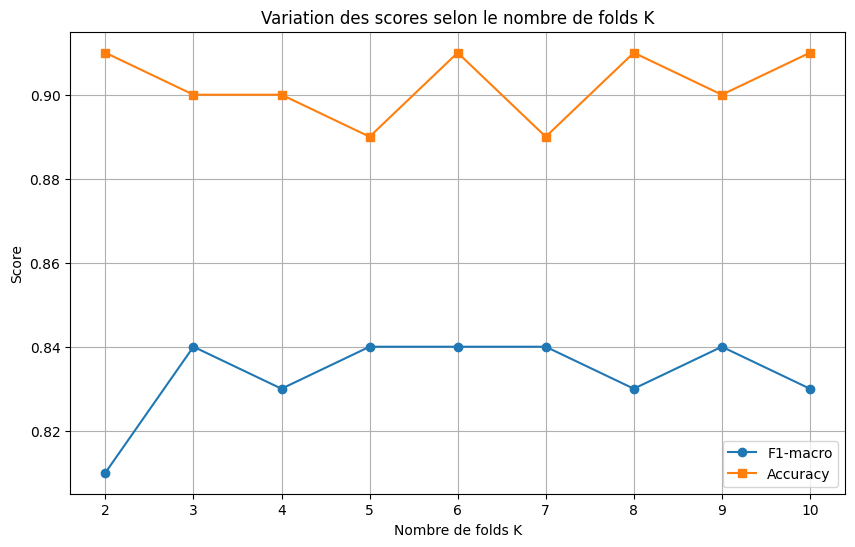

In [51]:
# Résultats pour chaque K
K_values = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
f1_scores = np.array([0.81, 0.84, 0.83, 0.84, 0.84, 0.84, 0.83, 0.84, 0.83])
accuracy_scores = np.array([0.91, 0.90, 0.90, 0.89, 0.91, 0.89, 0.91, 0.90, 0.91])

# Calcul de la variance
f1_variance = np.var(f1_scores)
accuracy_variance = np.var(accuracy_scores)

print(f"Variance F1-macro : {f1_variance:.4f}")
print(f"Variance Accuracy : {accuracy_variance:.4f}")

# Graphique des scores en fonction de K
plt.figure(figsize=(10, 6))
plt.plot(K_values, f1_scores, marker='o', label='F1-macro')
plt.plot(K_values, accuracy_scores, marker='s', label='Accuracy')
plt.xlabel('Nombre de folds K')
plt.ylabel('Score')
plt.title('Variation des scores selon le nombre de folds K')
plt.grid(True)
plt.xticks(K_values)
plt.legend()
plt.show()


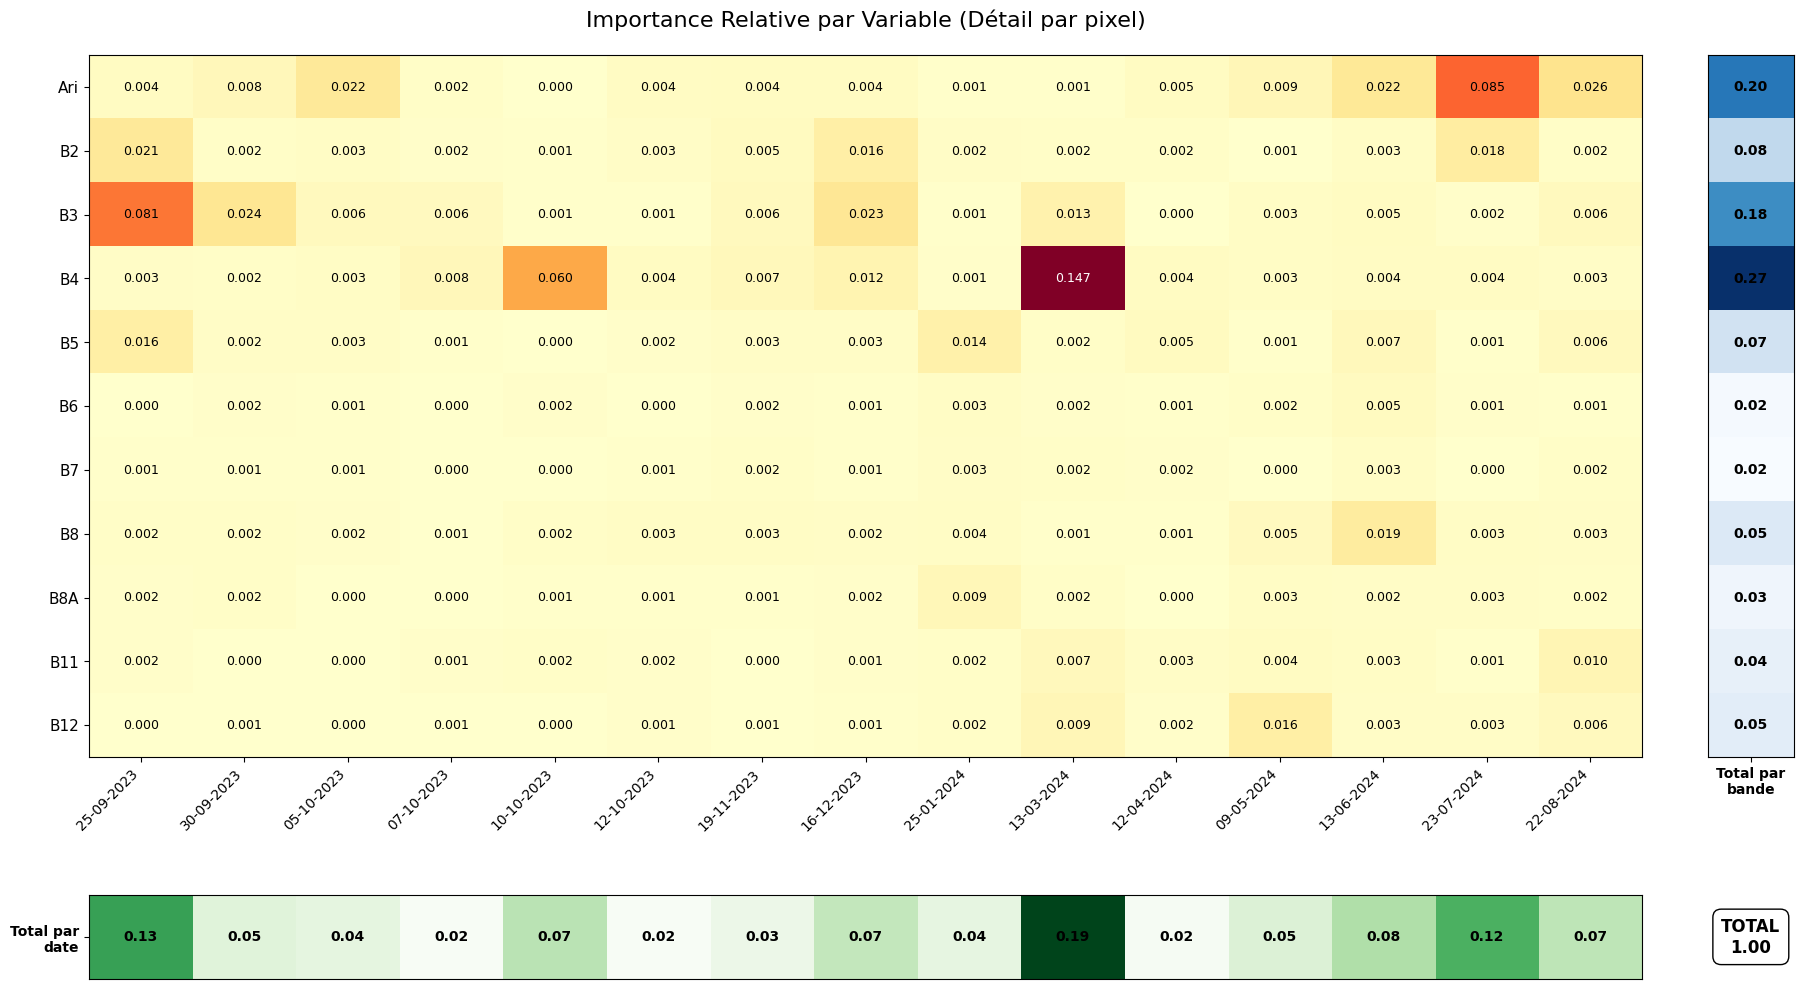

In [52]:
# 1. Préparation des données
layers = ["Ari", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"]
importances = best_model.feature_importances_
data_heatmap = []
idx = 0

for lyr in layers:
    for d in dates:
        data_heatmap.append({'Bande': lyr, 'Date': d, 'Importance': importances[idx]})
        idx += 1

df_heat = pd.DataFrame(data_heatmap)
df_heat['Date_dt'] = pd.to_datetime(df_heat['Date'], dayfirst=True)
df_heat = df_heat.sort_values('Date_dt')
sorted_dates = df_heat['Date'].unique()

pivot_table = df_heat.pivot(
    index='Bande',
    columns='Date',
    values='Importance'
).reindex(index=layers, columns=sorted_dates)

# Calcul des marges
total_bande = pivot_table.sum(axis=1).values.reshape(-1, 1)
total_date = pivot_table.sum(axis=0).values.reshape(1, -1)

# Configuration de la figure avec GridSpec
# Augmentation de hspace pour laisser passer les dates
fig = plt.figure(figsize=(22, 12))
gs = gridspec.GridSpec(
    2, 2,
    width_ratios=[18, 1],
    height_ratios=[10, 1.2],
    hspace=0.35,
    wspace=0.08
)

# Axe 1 : heatmap centrale
ax_main = plt.subplot(gs[0, 0])
im_main = ax_main.imshow(pivot_table.values, cmap="YlOrRd", aspect='auto')

ax_main.set_xticks(range(len(sorted_dates)))
ax_main.set_xticklabels(sorted_dates, rotation=45, ha="right", fontsize=10)
ax_main.set_yticks(range(len(layers)))
ax_main.set_yticklabels(layers, fontsize=11)
ax_main.set_title(
    "Importance Relative par Variable (Détail par pixel)",
    fontsize=16,
    pad=20
)

# Axe 2 : Total des bandes
ax_total_bande = plt.subplot(gs[0, 1])
im_bande = ax_total_bande.imshow(total_bande, cmap="Blues", aspect='auto')
ax_total_bande.set_xticks([0])
ax_total_bande.set_xticklabels(['Total par\nbande'], fontweight='bold', fontsize=10)
ax_total_bande.set_yticks([])

# Axe 3 : Total des dates
# Cet axe est maintenant descendu grâce au hspace=0.35
ax_total_date = plt.subplot(gs[1, 0])
im_date = ax_total_date.imshow(total_date, cmap="Greens", aspect='auto')
ax_total_date.set_yticks([0])
ax_total_date.set_yticklabels(['Total par\ndate'], fontweight='bold', fontsize=10)
ax_total_date.set_xticks([])  # On ne répète pas les dates ici car elles sont au-dessus

# Axe 4 : Total global
ax_total_all = plt.subplot(gs[1, 1])
total_val = pivot_table.values.sum()
ax_total_all.text(
    0.5, 0.5, f"TOTAL\n{total_val:.2f}",
    ha='center',
    va='center',
    fontweight='bold',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
ax_total_all.axis('off')

# Annotations numériques
# Données internes
for i in range(len(layers)):
    for j in range(len(sorted_dates)):
        val = pivot_table.values[i, j]
        color = "white" if val > pivot_table.values.max() * 0.6 else "black"
        ax_main.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=9, color=color)

# Totaux Bandes (Bleu)
for i, val in enumerate(total_bande.flatten()):
    ax_total_bande.text(0, i, f"{val:.2f}", ha="center", va="center", fontweight='bold', fontsize=10)

# Totaux Dates (Vert)
for j, val in enumerate(total_date.flatten()):
    ax_total_date.text(j, 0, f"{val:.2f}", ha="center", va="center", fontweight='bold', fontsize=10)

plt.show()


#### Analyse de l'importance des variables
L’analyse de l’importance des variables met en évidence une forte hétérogénéité dans la contribution des 165 descripteurs mobilisés par le modèle. Les résultats montrent que la performance de la classification repose principalement sur un nombre restreint de bandes spectrales et de périodes d’acquisition spécifiques, tandis qu’une majorité de variables présente une contribution marginale.

En effet, la bande B4 (rouge) joue un rôle prépondérant dans la discrimination des classes au début du printemps. Son importance atteint un maximum marqué lors de l’acquisition du 13 mars 2024, avec une valeur individuelle de 0,147, constituant le score le plus élevé observé sur l’ensemble des variables.

Toutefois, cette contribution décroît très rapidement par la suite, l’importance de la bande B4 chutant à 0,004 dès le mois d’avril. Cette évolution s’explique par la fermeture progressive de la canopée : lorsque la végétation atteint un stade de développement avancé, la réflectance dans le rouge tend à saturer et devient relativement homogène entre les différentes strates végétales. Dans ces conditions, la bande B4 perd une grande partie de son pouvoir discriminant. Justement, à partir de cette phase, l’indice Ari devient plus influent, en particulier durant l’été. Son importance relative augmente sensiblement en juillet (0,085) et demeure notable en septembre (0,022). Cet indice, sensible aux variations de pigments secondaires, permet de capter des différences physiologiques plus fines que celles observables à partir de la bande rouge brute, expliquant ainsi sa montée en importance à cette période.
 
Par ailleurs, Un élément notable de la série temporelle concerne la présence de quatre acquisitions rapprochées sur une période d’une semaine en octobre (05/10, 07/10, 10/10 et 12/10). Malgré cette densité temporelle élevée, l’importance cumulée associée à ces dates demeure faible, avec des valeurs comprises entre 0,02 et 0,04. Cette observation traduit une forte redondance de l’information spectrale. Les évolutions physiologiques de la végétation sur des intervalles si courts étant limitées, ces images successives apportent des informations très similaires au modèle.

Cette redondance se traduit par une dilution de l’importance attribuée à chaque date prise individuellement, ce qui explique la présence majoritaire de ces acquisitions parmi les variables classées comme les moins contributives. Le modèle n’a pas besoin de multiples répétitions d’un même état de la végétation pour opérer une discrimination efficace. De même, à l’échelle globale, l’agrégation des importances par bande confirme la prédominance des bandes du visible et des indices pigmentaires. Les bandes B4 (0,27), Ari (0,20) et B3 (0,18) concentrent à elles seules environ 65 % de l’importance totale du modèle. À l’inverse, l’analyse des vingt variables les moins contributives met en évidence une surreprésentation des bandes B6, B7, B11 et B12 sur plusieurs dates. Ces bandes associées au red-edge et à l’infrarouge semblent fournir une information redondante ou peu discriminante pour la séparation des strates végétales dans le cadre de ce modèle spécifique. 
Ainsi, il serait assez facile d'optimiser le temps de calcul du modèle en diminuant le nombre de bandes, notamment celles en dehors du visible. 


Création de la classification finale 

In [53]:
# Construction de X_full contenant nos bandes et l'ARI

arrays = []

for raster_path in rasters_X:
    ds = gdal.Open(raster_path)
    n_bands = ds.RasterCount

    for b in range(n_bands):
        band = ds.GetRasterBand(b + 1).ReadAsArray()
        arrays.append(band)

# Stack final : (rows, cols, n_features)
X_full = np.stack(arrays, axis=-1)
rows, cols, n_features = X_full.shape
print("Image shape :", X_full.shape)

# Création du masque de NoData
nodata_value = -9999
nodata_mask = np.any(X_full == nodata_value, axis=2)

# Flatten pour prédiction
X_flat = X_full.reshape(-1, n_features)
nodata_mask_flat = nodata_mask.flatten()

# Prédiction
y_pred_flat = np.zeros(X_flat.shape[0], dtype=np.uint8)
valid_pixels = ~nodata_mask_flat

y_pred_flat[valid_pixels] = best_model.predict(
    X_flat[valid_pixels]
)

# Remise en image du tableau numpy 
y_pred_img = y_pred_flat.reshape(rows, cols)

# Sauvegarde en GeoTIFF
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(
    output_carte_final,
    cols,
    rows,
    1,
    gdal.GDT_Byte
)

out_ds.SetGeoTransform(geotransform)
out_ds.SetProjection(projection)

band_out = out_ds.GetRasterBand(1)
band_out.SetNoDataValue(0)  
band_out.WriteArray(y_pred_img)

band_out.FlushCache()
out_ds.FlushCache()
out_ds = None

print(f"Carte des strates créée avec succès : {output_carte_final}")


Image shape : (1655, 2103, 165)
Carte des strates créée avec succès : /home/onyxia/work/Projet_telea_RIGAL_Gabriel/results/carte_strates.tif


Création de la matrice de confusion 

/tmp/ipykernel_10616/1185754660.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


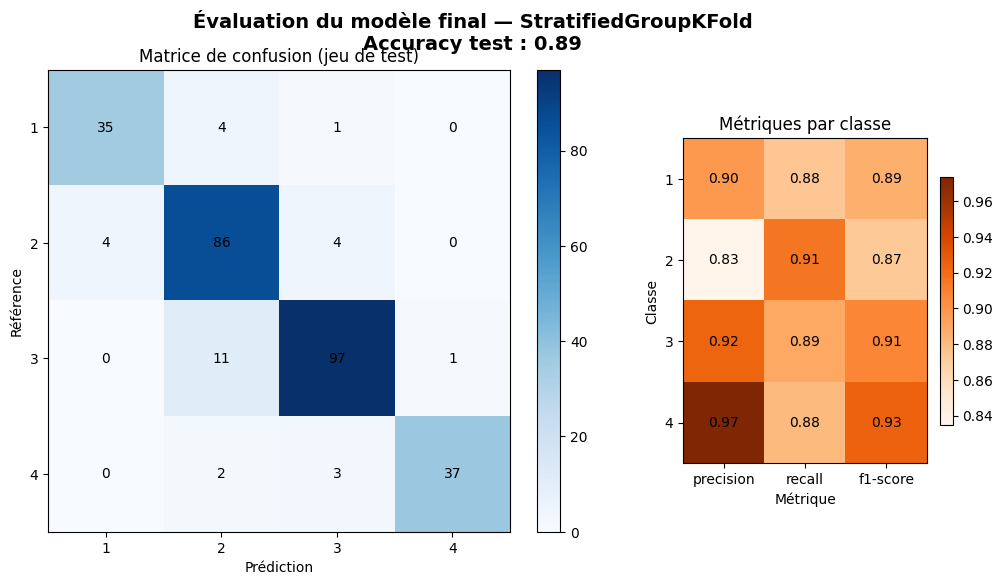

In [54]:
# Classes présentes
classes = np.unique(y_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Rapport de classification
report_dict = classification_report(
    y_test,
    y_pred,
    output_dict=True
)

# Classes
class_labels = [str(c) for c in classes]

metrics_df = (
    pd.DataFrame(report_dict)
    .T
    .loc[class_labels, ["precision", "recall", "f1-score"]]
)

# Repasser les index en int pour l'affichage
metrics_df.index = classes

# Figure
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)

# Matrice de confusion 
ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(cm_df.values, cmap="Blues")

ax0.set_xticks(range(len(classes)))
ax0.set_yticks(range(len(classes)))
ax0.set_xticklabels(classes)
ax0.set_yticklabels(classes)
ax0.set_xlabel("Prédiction")
ax0.set_ylabel("Référence")
ax0.set_title("Matrice de confusion (jeu de test)")

# Annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        ax0.text(
            j, i, cm_df.iloc[i, j],
            ha="center", va="center", color="black"
        )

fig.colorbar(im0, ax=ax0, fraction=0.046)

# Métriques par classe
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(metrics_df.values, cmap="Oranges")

ax1.set_xticks(range(metrics_df.shape[1]))
ax1.set_yticks(range(metrics_df.shape[0]))
ax1.set_xticklabels(metrics_df.columns)
ax1.set_yticklabels(metrics_df.index)
ax1.set_title("Métriques par classe")
ax1.set_xlabel("Métrique")
ax1.set_ylabel("Classe")

# Annotations
for i in range(metrics_df.shape[0]):
    for j in range(metrics_df.shape[1]):
        ax1.text(
            j, i, f"{metrics_df.iloc[i, j]:.2f}",
            ha="center", va="center", color="black"
        )

fig.colorbar(im1, ax=ax1, fraction=0.046)

# Accuracy globale
oa = accuracy_score(y_test, y_pred)

fig.suptitle(
    f"Évaluation du modèle final — StratifiedGroupKFold\nAccuracy test : {oa:.2f}",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()


### Analyse des performances de classification (Matrice de confusion)

Avant de procéder à une analyse particulière de la matrice, il convient de préciser que cette dernière n'est qu'un indicateur de la précision du modèle, et ne reflète que partiellement la réalité du modèle à partir des seuls polygones d'entraînements et de tests. Ainsi, il est indispensable de ne pas s'arrêter aux seules données chiffrées de la matrice de confusion qui pourrait laisser croire que le modèle est quasi parfait. C'est en ce sens qu'une analyse de la carte sera réalisée. On pourra dores et déjà constater que la matrice semble plus clémente que ce qu'elle ne devrait.

Par ailleurs, comme nous l'avons vu plus tôt, l’évaluation du modèle affiche une Accuracy test de 0.90. Toutefois, cette métrique globale s'avère insuffisante pour juger de la fiabilité du classifieur en raison du déséquilibre des effectifs entre les strates. Dans ce contexte, l’analyse du F1-score est donc privilégiée puisqu'en tant que moyenne harmonique entre la précision et le rappel, elle offre une mesure plus robuste de la performance réelle pour chaque classe, indépendamment de son poids dans l'échantillonnage.

Ainsi, la classe 4 (arbre) obtient le F1-score le plus élevé de l'étude (0.94). Cette performance souligne une excellente discrimination spectrale de cette strate. Le modèle parvient à maintenir un équilibre optimal entre une précision de 0.97 et un rappel de 0.90, confirmant que les signatures arborées sont nettement différenciées des strates végétalisées, limitant ainsi les risques de confusion systématique.

Pour ce qui est de la classe 2 (herbe), qui constitue la classe majoritaire, elle présente un F1-score de 0.89. On observe ici l'intérêt de ne pas se fier à la seule Accuracy : si le rappel est élevé (0.93), indiquant que peu de zones enherbées sont manquées, la précision chute à 0.85. Ce décalage traduit une propension du modèle à classer par défaut d'autres strates vers l'herbe, gonflant artificiellement le rappel au détriment de la fiabilité de la prédiction. Ces résultats restent néanmoins plus que corrects dans le cadre d'une classification.

La classe 1 (sol nu) quant-à-elle s'avère être la plus complexe à modéliser avec le F1-score le plus faible (0.88). Le rappel chute à 0.85, révélant une confusion majeure : 6 segments de sols nus sont identifiés comme de la classe 2 (herbe) ou 3 (lande). Cette porosité entre les deux strates suggère que la signature spectrale du sol est souvent "absorbée" par celle de l'herbe ou des landes. Le F1-score met ici en lumière une difficulté du modèle à isoler les caractéristiques propres au sol nu, probablement en lien avec le fait qu'il renvoie à des réalités parfois hétérogène comme les chemins de terres et les routes, bien que ces dernières puissent être relativement proche des roches de montagne que le modèle devrait également détecter.

Enfin, la classe 3 (lande) affiche un F1-score de 0.91, proche de l'accuracy globale. Bien que la précision soit élevée (0.92), le rappel de 0.90 indique un problème relatif lié à la détection des classes 1 et 2. Le modèle est sélectif lorsqu'il prédit la classe 4 (arbre), mais il échoue à capturer l'exhaustivité des landes, les confondant occasionnellement avec la classe 1 et 2 (sol nu et herbe). Ces erreurs peuvent ainsi être interprété par une confusion du classifieur entre de hautes herbes et des landes relativement basses.

 ### Analyse des performances de classification (comparaison classification et Ortho IRC 2024)


Cette première image permet de constater l'état global de la classification. Il apparaît alors que dans l'ensemble, les différents éléments distingables sur la photographie aérienne sont visibles sur la Classification. Les éléments en question sont mis en avant par des polygones. Par ailleurs, il est important de noter que la légende de la classification est la même pour toutes les images de cette dernière.
![L'image comparaison_vue_generale.png devrait s'afficher, merci de vérifier vos chemins](/home/onyxia/work/Projet_telea_RIGAL_Gabriel/img/comparaison_vue_generale.png "Vue générale de la classification")

On constate ici assez facilement que les grands éléments de la zone d'étude sont constatés par la classification. La stratification arbre, herbe,landes, sol nu (roche) semble apparaître au niveau des montagne. 
En effet, le polygone A permet de constater que les sommets rocheux sont bien classés. Le polygone B quant-à-lui permet de constater que la classification semble bien gérer les différences de reflectances en attribuant les classes d'herbe et de lande au sein d'une zone dans laquelle l'image Ortho IRC nous permet de constater un mélange d'éléments distincts (au moins au niveau de leur réflectance). Le polygone C permet de constater que le modèle détecte bien les arbres puisqu'il entoure une forêt détectée comme telle (classe arbre). Le polygone D est composé d'herbes, de landes et de roche. On constate ici que la classification est valable et qu'elle arrive à différencier les différents objets. Enfin, le polygone E montre quant-à-lui les faiblesses de la classification. En effet, il n'est pas difficile de constater que les ensembles d'éléments que l'on retrouve sur la photographie aérienne ne sont pas forcément retrouvés dans la classification. Certains éléments apparaissent par ailleurs de manière plus réduite ou déformés. Pour autant, à l'échelle 1/80000, la classification semble cohérente.


L'image qui suit permet de constater les limites de la classification de la classe 1. En effet, les polygones rouges représentant une masse à l'intérieur de laquelle devrait se trouver des pixels classés comme sol nu. Ce n'est pourtant pas le cas, puisque la majorité est classé comme arbre. Or il s'agit d'un village et de routes. Ainsi, on constate que le modèle n'est pas précis au point de différencier les routes et les habitations des arbres. Cela peut être expliqué par deux choses : la première serait l'idée que, avec des pixels de 10m par 10m, le village et les routes sont absorbés par la taille des pixels, faisant qu'ils ne ressortent pas particulièrement sur le modèle. Cette idée est particulièrement vraie pour les routes, mais semble trouver ses limites au sein des villages. Une autre explication serait l'idée selon laquelle la classe de sol nu n'a pas été assez entraînée sur des éléments de routes et de villages mais plutôt sur de la roche de montagne. Or, bien que leur réflectance se ressemble, ce ne sont pas les mêmes éléments, et puisque nous avons constaté que l'écart type de la classe de sol nu peut être situé dans toutes les classes, on peut imaginer une confusion à ce niveau-là. Il apparaît alors que la confusion constatée via la matrice s'applique logiquement à la carte, bien qu'elle omette la confusion avec des classes d'arbres. Ainsi, la matrice semble avoir sur évalué la performance du modèle pour la classe 1, bien qu'on puisse constater un bon résultat à l'échelle de la classification entière. 

![L'image zoom_route_et_ville.png devrait s'afficher, merci de vérifier vos chemins](/home/onyxia/work/Projet_telea_RIGAL_Gabriel/img/zoom_route_et_ville.png "Analyse particulière de la classe 1")


La même réflexion peut être faite avec les autres classes. Ainsi, l'image suivante permet de reprendre cette même idée avec les 3 classes restantes. On pourra par ailleurs constater que, lorsqu'on on regarde le détail de la classification, certains pixels n'apparaissent pas. Cela s’explique par la présence de valeurs NoData (-9999) dans au moins une bande de la série temporelle, entraînant l’exclusion de ces pixels lors de la phase de prédiction afin de garantir la cohérence spectro-temporelle des données utilisées.
![L'image comparaison_vue_zoom.png devrait s'afficher, merci de vérifier vos chemins](/home/onyxia/work/Projet_telea_RIGAL_Gabriel/img/comparaison_vue_zoom.png "Comparaison d'une zone représentant la classification ")

Cette image nous permet assez facilement de nous rendre compte d'un fait essentiel pour comprendre cette classification : les pixels sur lesquels cette dernière est construite ont une taille de 10m sur 10m. Ainsi, il n'est pas étonnant de constater que des erreurs peuvent s'immisser lorsqu'on la compare à une image où les pixels se comptent en centimètres. Il n'en reste que, en dehors des chemins qui disparaissent complètement, on peut facilement constater que la classification, bien que sur-évaluée par la matrice de confusion, reste pertinente. En effet, la classe des arbres semble la mieux classifiée, sûrement car elle est composée d'éléments relativement homogènes. Pour ce qui est de la classe de landes, on constate qu'elle se mélange avec l'herbe. Pour autant, il est assez difficile de photo interpréter la différence entre certaines herbes hautes et certaines landes basses par exemple. Il apparaît alors complexe de différencier là où s'arrête une classe et là où commence une autre. Cela est totalement logique. En effet, comme on peut le voir dans l'image ci-dessous, la classification est déterminée par des polygones eux-mêmes difficiles à interpréter.
Ces résultats nous permettent de poser certaines idées quant-à l'utilisation de cette classification.
![L'image polygones_herbes_landes.png devrait s'afficher, merci de vérifier vos chemins](/home/onyxia/work/Projet_telea_RIGAL_Gabriel/img/polygones_herbe_landes.png "Exemple de polygones d'entraînement d'herbe et de landes")


### Conclusion : 

La classification semble donc très pertinente à son échelle. Ainsi, elle pourrait par exemple permettre d'identifier des sites où la présence de landes est probable, permettant ensuite, dans le cas où ce serait utile et après une étape de validation de la classification par photo-interprétation, l'établissement de zones d'études à aller constater sur le terrain. Cette classe peut également s'avérer utile dans le cadre d'une caractérisation de l'état des montagne relatif à l'avancée d'espèces pionnières et la détermination de la nécessité de la réalisation d'écobuage par exemple.
Une limite importante de la méthodologie serait par ailleurs le nombre trop faible de sites photo-interprétés, nous empêchant ainsi de construire une matrice de confusion représentative de la réalité. En effet, dans la mesure où les sites sont divisés en deux entre les sites d'entraînements et les sites tests, un peu plus de 200 sites, répartis inégalement par ailleurs, semble trop peu. De même, ces sites sont répartis en bloc de trois espaces, ce qui peut aussi créer des problèmes.
Dans le cadre de la mission, la classification semble cohérente, mais une discussion sur ces limites serait à préciser aux commanditaires. Le fait que l'on puisse distinguer les différentes strates de végétation sur notre classification peut par ailleurs nous permettre d'interpréter ces résultats comme témoignant assez franchement de la présence de landes dans notre zone d'étude, notamment dans des zones plus élevées que les forêts et l'herbe, juste avant la strate rocheuse de la montagne.

